# 7506 - Trabajo práctico 1


##### Librerías

In [1]:
import pandas as pd
from pandas.plotting import scatter_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd

import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

In [121]:
from IPython.display import display, HTML


def display_side_by_side(dfs: list, captions: list):
    """Display tables side by side to save vertical space
    Input:
        dfs: list of pandas.DataFrame
        captions: list of table captions
    """
    output = ""
    combined = dict(zip(captions, dfs))
    for caption, df in combined.items():
        output += df.style.set_table_attributes("style='display:inline'").set_caption(caption)._repr_html_()
        output += "\xa0\xa0\xa0"
    display(HTML(output))

In [122]:
complete_dataset = pd.read_csv("./datasets/properati_argentina_2021.csv")
df = complete_dataset.copy()

## Análisis Exploratorio y Preprocesamiento de Datos

Primero, observaremos un poco los datos que tiene el dataset

**Primeras 5 observaciones**

In [123]:
df.head()

,id,start_date,end_date,created_on,latitud,longitud,place_l2,place_l3,place_l4,place_l5,place_l6,operation,property_type,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,property_currency,property_title
0,XZq2dFGxBiboHY3Bo/tqlw==,2021-09-09,2022-01-27,2021-09-09,-38.957632,-68.105443,Neuquén,NaN,NaN,NaN,NaN,Venta,Casa,6.0,NaN,NaN,206.0,NaN,NaN,Casa - Capital
1,8afoK+yMH/rnnlYiktwgNA==,2021-09-09,2021-10-23,2021-09-09,-34.888878,-56.092368,Montevideo,NaN,NaN,NaN,NaN,Venta,Casa,4.0,3.0,193.0,193.0,390000.0,USD,Casa - Malvín
2,iVaG5rBB47dd1Ya4BMXREA==,2021-09-09,2022-03-09,2021-09-09,-32.488717,-58.257499,Entre Ríos,NaN,NaN,NaN,NaN,Venta,Casa,NaN,NaN,110.0,45.0,47000.0,USD,Casa - Uruguay
3,QE1QVMWKAHWkd0qT0FtPWA==,2021-09-09,2022-01-27,2021-09-09,-34.900165,-54.808453,Maldonado,NaN,NaN,NaN,NaN,Venta,Casa,NaN,3.0,NaN,180.0,400000.0,USD,Casa - El Chorro
4,tJ5lSk7IysG/71OGhacNZA==,2021-09-09,2022-01-27,2021-09-09,-38.954528,-68.041862,Neuquén,NaN,NaN,NaN,NaN,Venta,PH,3.0,2.0,NaN,98.0,102000.0,USD,PH - Villa Farrell


In [124]:
print(f"El dataset tiene {df.shape[0]} filas y {df.shape[1]} columnas")

El dataset tiene 62633 filas y 20 columnas


In [125]:
df.describe()

,latitud,longitud,place_l6,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price
count,57103.000000,57103.000000,0.0,50765.000000,47432.000000,54614.000000,5.810900e+04,6.017200e+04
mean,-34.284699,-59.522774,NaN,3.278499,2.296677,372.878896,6.445757e+02,2.885600e+05
std,3.028603,2.860077,NaN,1.893980,1.487476,3709.300125,3.112059e+04,4.910084e+06
min,-54.832057,-83.276187,NaN,1.000000,-1.000000,10.000000,1.000000e+00,0.000000e+00
25%,-34.644631,-58.885654,NaN,2.000000,1.000000,50.000000,4.500000e+01,4.300000e+04
50%,-34.586182,-58.486522,NaN,3.000000,2.000000,87.000000,7.600000e+01,9.650500e+04
75%,-34.426166,-58.404681,NaN,4.000000,3.000000,206.000000,1.650000e+02,1.980000e+05
max,42.440292,-35.044991,NaN,35.000000,74.000000,200000.000000,5.000000e+06,1.111111e+09


In [126]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62633 entries, 0 to 62632
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   id                        62633 non-null  object 
 1   start_date                62633 non-null  object 
 2   end_date                  62633 non-null  object 
 3   created_on                62633 non-null  object 
 4   latitud                   57103 non-null  float64
 5   longitud                  57103 non-null  float64
 6   place_l2                  62633 non-null  object 
 7   place_l3                  59749 non-null  object 
 8   place_l4                  18796 non-null  object 
 9   place_l5                  356 non-null    object 
 10  place_l6                  0 non-null      float64
 11  operation                 62632 non-null  object 
 12  property_type             62632 non-null  object 
 13  property_rooms            50765 non-null  float64
 14  proper

In [127]:
df.dtypes

id                           object
start_date                   object
end_date                     object
created_on                   object
latitud                     float64
longitud                    float64
place_l2                     object
place_l3                     object
place_l4                     object
place_l5                     object
place_l6                    float64
operation                    object
property_type                object
property_rooms              float64
property_bedrooms           float64
property_surface_total      float64
property_surface_covered    float64
property_price              float64
property_currency            object
property_title               object
dtype: object

## Descripción de las columnas
- type - Tipo de aviso (Propiedad, Desarrollo/Proyecto).
- country - País en el que está publicado el aviso (Argentina, Uruguay, Colombia, Ecuador, Perú)
- id - Identificador del aviso. No es único: si el aviso es actualizado por la inmobiliaria (nueva versión del aviso) se crea un nuevo registro con la misma id pero distintas fechas: de alta y de baja.
- start_date - Fecha de alta del aviso.
- end_date - Fecha de baja del aviso.
- created_on - Fecha de alta de la primera versión del aviso.
- place - Campos referidos a la ubicación de la propiedad o del desarrollo.

   - lat - Latitud.

   - lon - Longitud.

   - l1 - Nivel administrativo 1: país.

   - l2 - Nivel administrativo 2: usualmente provincia.

   - l3 - Nivel administrativo 3: usualmente ciudad.

   - l4 - Nivel administrativo 4: usualmente barrio.
- property - Campos relativos a la propiedad (vacío si el aviso es de un desarrollo/proyecto).

   - operation - Tipo de operación (Venta, Alquiler).

   - type - Tipo de propiedad (Casa, Departamento, PH).

   - rooms - Cantidad de ambientes (útil en Argentina).

   - bedrooms - Cantidad de dormitorios (útil en el resto de los países).

   - bathrooms - Cantidad de baños.

   - surface_total - Superficie total en m².

   - surface_covered - Superficie cubierta en m².

   - price - Precio publicado en el anuncio.

   - currency - Moneda del precio publicado.

   - price_period - Periodo del precio (Diario, Semanal, Mensual)

   - title - Título del anuncio.

   - description - Descripción del anuncio.
- development - Campos relativos al desarrollo inmobiliario (vacío si el aviso es de una propiedad).
- status - Estado del desarrollo (Terminado, En construcción, ...)
- name - Nombre del desarrollo.
- short_description - Descripción corta del anuncio.
- description - Descripción del anuncio.


## Filtrado inicial del Dataset
Como trabajaremos con un universo acotado de propiedades, haremos una selección inicial de las publicaciones que nos interesa analizar:

Como primer paso hay que filtrar las observaciones que su tipo de vivienda sea: Casa, PH o Departamento.

Luego filtramos la ubicacion quedandonos unicamente con las propiedades de Capital Federal.

A continuación, consideraremos solo las que esten cotizadas en dolares.

Y finalmente, tomamos solo las que sean ventas

In [128]:
df_tipo_vivienda = df[(df.property_type == "Casa") | (df.property_type == "PH") | (df.property_type == "Departamento")]
df_por_ubicacion = df_tipo_vivienda[
    (df_tipo_vivienda.place_l2 == "Capital Federal") | (df_tipo_vivienda.place_l3 == "Capital Federal")]
df_cotizacion_usd = df_por_ubicacion[df_por_ubicacion.property_currency == "USD"]
ds_filtrado = df_cotizacion_usd[df_cotizacion_usd.operation == "Venta"]

ds_filtrado[["place_l2", "place_l3", "property_currency", "property_type", "operation"]]

,place_l2,place_l3,property_currency,property_type,operation
25,Capital Federal,NaN,USD,Casa,Venta
42,Capital Federal,Boca,USD,Departamento,Venta
43,Capital Federal,Boca,USD,Departamento,Venta
49,Capital Federal,Once,USD,Departamento,Venta
51,Capital Federal,Boedo,USD,PH,Venta
...,...,...,...,...,...
62607,Capital Federal,Saavedra,USD,PH,Venta
62608,Capital Federal,Caballito,USD,PH,Venta
62609,Capital Federal,Chacarita,USD,PH,Venta
62612,Capital Federal,Villa Devoto,USD,PH,Venta


A partir de aquí trabajaremos con el dataset filtrado (`ds_filtrado`)

Analizando los tipos de dato de los campos:
- Hay 3 campos de fecha, evaluaremos más adelante como tratarlos.
- Tenemos latitud y longitd en su formato correcto
- Hay una variable place_l6 que no debería ser un número, también analizaremos a que se debe.
- La cantidad de habitaciones (rooms y bedrooms) quizás debería tener valores enteros.
- El precio tiene un tipo correcto

## Exploración Inicial

### Tipos de variable

In [129]:
# TODO: Tipos de variables

# Categoricas o Cuantitivas
    # Fechas -> Start Date y End Date
    # Places -> l2, l3, l4, l5, l6
    # Operacion
    # Tipo de Propiedad
    # Currency
    # Property Title

# Cuasicuantitativas u ordinales

# Cuantitativas discretas
    # Rooms
    # Bedrooms
    # Surface -> Total y Covered
    # Price

# Cuantitativas continuas
    # Latitud y Longitud


categoricas = ['start_date', 'end_date', 'place_l2', 'place_l3', 'place_l4', 'place_l5', 'place_l6', 'operation', 'property_type', 'property_currency', 'property_title']
cuantitativas_discretas = ['property_rooms', 'property_bedrooms', 'property_surface_total', 'property_surface_covered']
cuantitativas_continuas = ['latitud', 'longitud']
tipos_de_variable = {'Categoricas': categoricas, 'Ordinales': [], 'Cuantitativas Discretas': cuantitativas_discretas, 'Cuantitativas Continuas': cuantitativas_discretas}

cuantitativas = cuantitativas_discretas + cuantitativas_continuas

tipos_de_variable

{'Categoricas': ['start_date',
  'end_date',
  'place_l2',
  'place_l3',
  'place_l4',
  'place_l5',
  'place_l6',
  'operation',
  'property_type',
  'property_currency',
  'property_title'],
 'Ordinales': [],
 'Cuantitativas Discretas': ['property_rooms',
  'property_bedrooms',
  'property_surface_total',
  'property_surface_covered'],
 'Cuantitativas Continuas': ['property_rooms',
  'property_bedrooms',
  'property_surface_total',
  'property_surface_covered']}

### Fechas


In [130]:
ds_filtrado[["start_date", "end_date", "created_on"]].isna().sum()

start_date    0
end_date      0
created_on    0
dtype: int64

In [131]:
ds_filtrado["start_date"].value_counts()

2021-02-08    645
2021-06-24    534
2021-05-18    503
2021-10-01    493
2021-09-22    472
             ... 
2021-08-01     28
2021-12-05     23
2021-11-21     18
2021-12-19     13
2021-02-06      9
Name: start_date, Length: 63, dtype: int64

In [132]:
ds_filtrado["end_date"].value_counts()

2021-06-05    1757
2022-01-27    1038
9999-12-31     897
2022-02-09     705
2022-03-09     340
              ... 
2022-01-31       1
2022-01-30       1
2022-07-18       1
2022-02-21       1
2021-06-27       1
Name: end_date, Length: 546, dtype: int64

In [133]:
ds_filtrado[ds_filtrado.created_on != ds_filtrado.start_date].shape

(0, 20)

Podemos ver que la columnas created_on y start_date siempre son iguales, descartaremos una de ellas más adelante.

In [134]:
ds_filtrado["created_on"].value_counts()

2021-02-08    645
2021-06-24    534
2021-05-18    503
2021-10-01    493
2021-09-22    472
             ... 
2021-08-01     28
2021-12-05     23
2021-11-21     18
2021-12-19     13
2021-02-06      9
Name: created_on, Length: 63, dtype: int64

Hay un valor extraño en end_date, la fecha 9999-12-31, hay 5041 apariciones de esta fecha

In [135]:
ds_filtrado[ds_filtrado.end_date == '9999-12-31']['start_date'].value_counts()

2021-02-09    132
2021-06-24    122
2021-07-06     66
2021-07-30     47
2021-06-10     44
2021-07-19     42
2021-07-05     41
2021-02-08     40
2021-01-25     37
2021-06-23     26
2021-01-26     26
2021-01-27     25
2021-01-13     22
2021-02-20     19
2021-10-15     19
2021-08-28     14
2021-11-23     13
2021-10-29     13
2021-01-11     13
2021-10-16     12
2021-07-31     11
2021-08-16     11
2021-01-12     10
2021-08-01      9
2021-08-14      8
2021-08-15      8
2021-12-17      7
2021-07-04      7
2021-09-22      6
2021-08-29      6
2021-12-03      6
2021-07-18      5
2021-02-07      4
2021-04-21      3
2021-04-09      2
2021-04-20      2
2021-10-17      2
2021-12-30      2
2021-02-06      2
2021-03-29      2
2021-09-20      2
2021-03-28      1
2021-05-02      1
2021-09-21      1
2021-12-04      1
2021-12-19      1
2021-05-03      1
2021-10-01      1
2021-05-18      1
2021-09-09      1
Name: start_date, dtype: int64

Considerando que todas las fechas son de 2021, y que el dato que falta es el del fin de la publicación (es decir, la casa esta publicada) y a fines de preservar estos datos, traeremos a consideración la duración promedio de cada publicación, calcularemos ese promedio dejando fuera los 5041 casos que presentan la fecha inválida.

Tomaremos para el cálculo las fechas convertidas a datetime.

In [136]:
dias = pd.to_datetime(ds_filtrado[ds_filtrado.end_date != '9999-12-31']['end_date']) - pd.to_datetime(
    ds_filtrado[ds_filtrado.end_date != '9999-12-31']['start_date'])
dias.describe()

count                         12032
mean     80 days 11:45:16.755319149
std      91 days 19:57:25.912059936
min                 0 days 00:00:00
25%                18 days 00:00:00
50%                46 days 00:00:00
75%               117 days 00:00:00
max               611 days 00:00:00
dtype: object

El promedio de la duración de las publicaciones es casi de 75 días, asumiremos que las publicaciones con la fecha invalida duraron lo mismo que el promedio y tomaremos como fecha final la fecha de inicio + 75 días.

In [137]:
ds_filtrado.loc[ds_filtrado.end_date == '9999-12-31', 'end_date'] = pd.to_datetime(
    ds_filtrado[ds_filtrado.end_date == '9999-12-31']['start_date']) + dias.mean()
ds_filtrado.end_date

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


25                          2021-09-26
42                          2021-09-26
43                          2021-09-28
49                          2022-01-05
51                          2022-03-09
                     ...              
62607                       2021-06-05
62608                       2021-02-09
62609    2021-04-27 11:45:16.755319149
62612    2021-04-27 11:45:16.755319149
62613                       2021-02-18
Name: end_date, Length: 12929, dtype: object

Finalmente, como todos los valores son formatos válidos de fecha, podemos convertir sin problemas.

### Conversion tipo de dato

In [138]:
new_ds = ds_filtrado.copy()
new_ds.start_date = pd.to_datetime(new_ds.start_date, infer_datetime_format=True)
new_ds.end_date = pd.to_datetime(new_ds.end_date, infer_datetime_format=True)
new_ds.created_on = pd.to_datetime(new_ds.created_on, infer_datetime_format=True)
ds_filtrado = new_ds.copy()
ds_filtrado.dtypes

id                                  object
start_date                  datetime64[ns]
end_date                    datetime64[ns]
created_on                  datetime64[ns]
latitud                            float64
longitud                           float64
place_l2                            object
place_l3                            object
place_l4                            object
place_l5                            object
place_l6                           float64
operation                           object
property_type                       object
property_rooms                     float64
property_bedrooms                  float64
property_surface_total             float64
property_surface_covered           float64
property_price                     float64
property_currency                   object
property_title                      object
dtype: object

## Variables Cuantitativas: calcular medidas de resumen: media, mediana, q1, q3, moda

In [139]:
# Variables Cuantitativas: calcular medidas de resumen: media, mediana, q1, q3, moda
description_quantitatives = ds_filtrado[cuantitativas].describe()

quantitative_mode = ds_filtrado[cuantitativas].mode()
quantitative_mode.rename(index={0: "mode"}, inplace=True)
description_quantitatives = description_quantitatives.append(quantitative_mode)

description_quantitatives.rename(index={"25%":"quartile 1","50%":"median","75%":"quartile 3"}, inplace=True)
description_quantitatives

,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,latitud,longitud
count,12747.000000,11396.000000,12230.000000,12413.000000,12405.000000,12405.000000
mean,2.804111,2.005879,94.190679,95.588899,-34.586178,-58.459855
std,1.417313,1.142985,155.257158,1950.726975,0.218587,0.372401
min,1.000000,1.000000,10.000000,1.000000,-41.163826,-71.438923
quartile 1,2.000000,1.000000,45.000000,40.000000,-34.616124,-58.467705
median,3.000000,2.000000,64.000000,57.000000,-34.595180,-58.440018
quartile 3,4.000000,3.000000,102.000000,87.000000,-34.576571,-58.409178
max,30.000000,32.000000,10500.000000,217000.000000,-24.770804,-58.343239
mode,3.000000,1.000000,50.000000,40.000000,-34.584596,-58.464357


## Variables Cualitativas mostrar cantidad de valores posibles, y frecuencias de cada uno.

In [140]:
qualitative_dataset = ds_filtrado[categoricas]

dfs = list(
    pd.DataFrame(qualitative_dataset[column].value_counts().head()) for column in qualitative_dataset.columns.tolist())
display_side_by_side(dfs, qualitative_dataset.columns.tolist())

,start_date
2021-02-08 00:00:00,645
2021-06-24 00:00:00,534
2021-05-18 00:00:00,503
2021-10-01 00:00:00,493
2021-09-22 00:00:00,472
,end_date
2021-06-05 00:00:00,1757
2022-01-27 00:00:00,1038
2022-02-09 00:00:00,705
2022-03-09 00:00:00,340


La tabla muestra varias cosas:
- Hay 94249 propiedades habiendo filtrado solo las de Capital Federal, Venta y USD
- Hay 80829 departamentos, 9266 PHs y 4154 casas
- Hay 14308 propiedades en Palermo
- El id de la propiedad es único y no representa nada útil para nuestro procesamiento. Parecería pasar algo similar con el título, lo analizaremos en más detalle más adelante

## Correlación entre variables

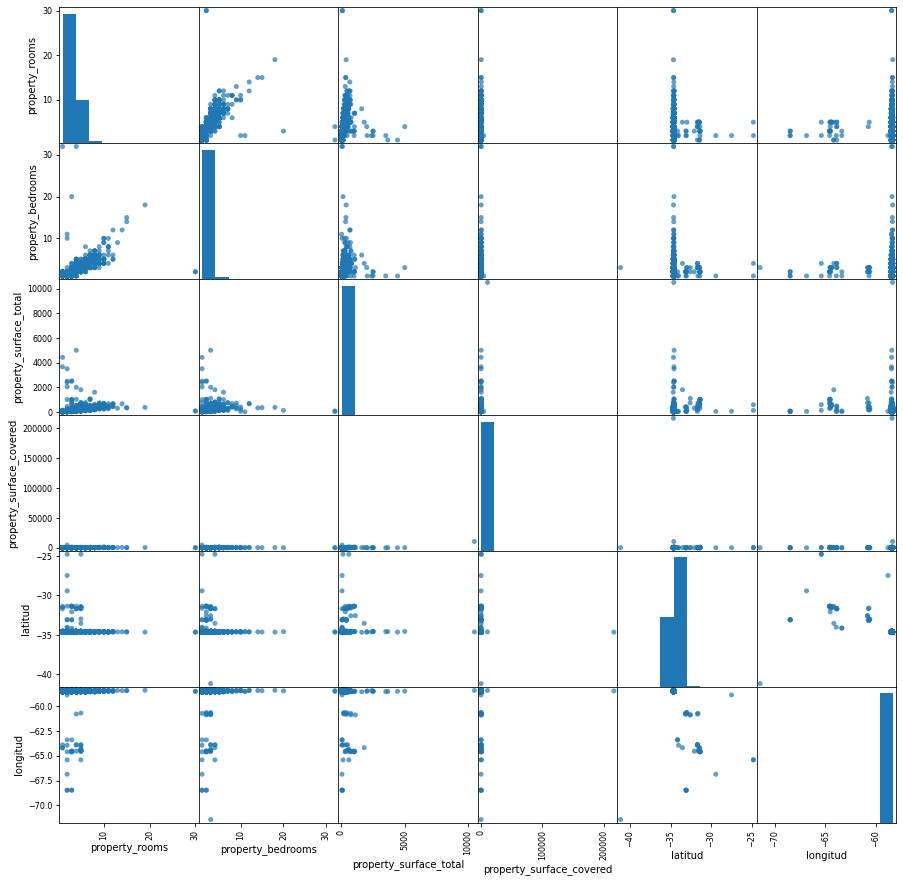

In [141]:
# Realizar un análisis gráfico de las distribuciones de las variables

quantitative_dataset = ds_filtrado[cuantitativas]
ax = scatter_matrix(quantitative_dataset, alpha=0.7, figsize=(15, 15), s=100)

In [142]:
# Analizar las correlaciones existentes entre las variables.
quantitative_dataset.corr()

,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,latitud,longitud
property_rooms,1.000000,0.815838,0.465863,0.630251,0.014085,-0.018053
property_bedrooms,0.815838,1.000000,0.416846,0.543340,0.007658,-0.010246
property_surface_total,0.465863,0.416846,1.000000,0.730207,0.118738,-0.125203
property_surface_covered,0.630251,0.543340,0.730207,1.000000,0.000588,-0.001246
latitud,0.014085,0.007658,0.118738,0.000588,1.000000,-0.630282
longitud,-0.018053,-0.010246,-0.125203,-0.001246,-0.630282,1.000000


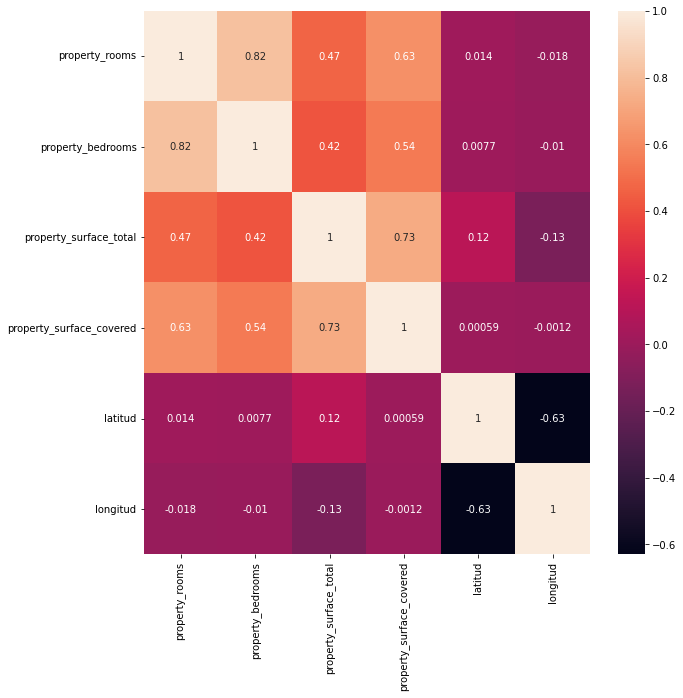

In [143]:
# Analizar las correlaciones existentes entre las variables.
plt.figure(figsize=(10, 10))
sns.heatmap(quantitative_dataset.corr(), annot=True)

## Análisis de valores faltantes

Ahora analizaremos los datos faltantes del dataset.

### Porcentaje de valores faltantes por columna



id                            0.000000
start_date                    0.000000
end_date                      0.000000
created_on                    0.000000
latitud                       4.052904
longitud                      4.052904
place_l2                      0.000000
place_l3                      0.564622
place_l4                     96.070848
place_l5                    100.000000
place_l6                    100.000000
operation                     0.000000
property_type                 0.000000
property_rooms                1.407688
property_bedrooms            11.857066
property_surface_total        5.406451
property_surface_covered      3.991028
property_price                0.000000
property_currency             0.000000
property_title                0.000000
dtype: float64


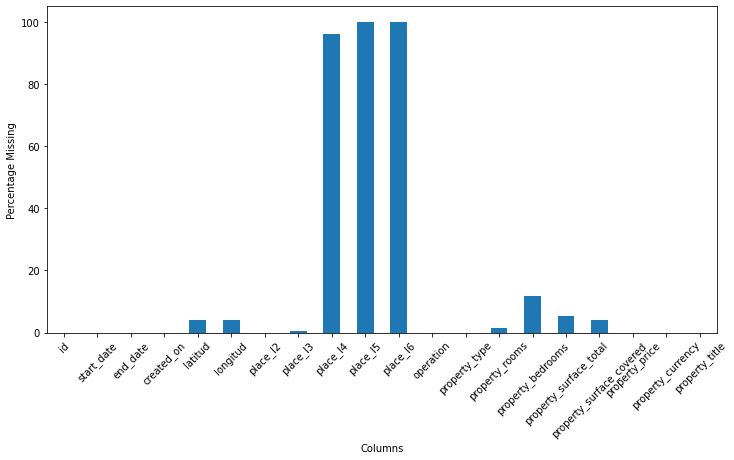

In [144]:
percent_missing = ds_filtrado.isna().sum() * 100 / len(ds_filtrado)
plt.figure(figsize=(12, 6))
percent_missing.plot.bar(x='index', rot=45)
plt.xlabel("Columns")
plt.ylabel("Percentage Missing")
rows = ds_filtrado.shape[0]
print(ds_filtrado.isna().sum() / rows * 100)

A simple vista podemos ver que las columnas place_l4,place_l5 y place_l6 practicamente no tienen datos, procederemos a eliminarlas.

### Porcentaje de datos faltantes por fila

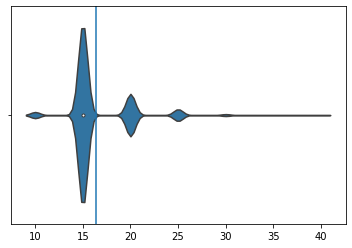

In [145]:
column_count = ds_filtrado.shape[1]
ds_plot = ds_filtrado.T.isna().sum() * 100 / column_count


plt.axvline(ds_plot.mean())
sns.violinplot(ds_plot)

Analizaremos nuevamente el porcentaje por fila luego de trabajar con las columnas

### Procesado de columnas

Descartaremos la columna id debido a que no es relevante para nuestro análisis. No podemos usar un dato uníco porque no representa ninguna característica relevante.

In [146]:
ds_filtrado['id'].head()

25    CyZu6IaZgmQYGk8jmPajCg==
42    d3Z0MblSb2IMBoOBMGJEEQ==
43    rL7qPkQnomsMGu2ViS3sBw==
49    vuX/ccLAMVml4qWRFcOJUA==
51    ZTtSCeqZ3HUgf5jjwEzRcw==
Name: id, dtype: object

Como mencionamos anteriormente, evaluaremos descartar place_l4 por la cantidad de valores faltantes que hay.

In [147]:
ds_filtrado['place_l4'].value_counts()

Palermo Hollywood    253
Palermo Chico        128
Palermo Soho         102
Palermo Viejo         25
Name: place_l4, dtype: int64

Como son pocas observaciones y todas corresponden al barrio de Palermo, descartaremos esta columna. Además, como mencionamos más arriba, la columna created_on siempre es igual a la columna start_date, por lo que también la descartaremos. 

In [148]:
properties_dataset = ds_filtrado.drop(axis="columns", columns=["id", "created_on", "place_l4", "place_l5", "place_l6"]).copy()
print(f"Nuestras nuevas columnas son:\n{properties_dataset.columns.tolist()}")

Nuestras nuevas columnas son:
['start_date', 'end_date', 'latitud', 'longitud', 'place_l2', 'place_l3', 'operation', 'property_type', 'property_rooms', 'property_bedrooms', 'property_surface_total', 'property_surface_covered', 'property_price', 'property_currency', 'property_title']


### Analisis de faltantes por fila

Ahora que nos quedamos solo con las columnas deseadas, analizaremos nuevamente los datos faltantes por fila.

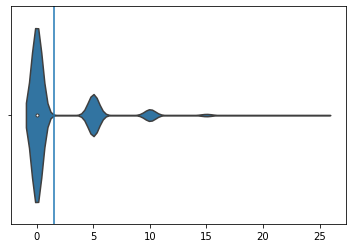

In [149]:
column_count = ds_filtrado.shape[1]
ds_plot = properties_dataset.T.isna().sum() * 100 / column_count

sns.violinplot(ds_plot)
plt.axvline(ds_plot.mean())

Como podemos ver en el gráfico, la cantidad de datos faltantes bajó muchísimo al eliminar las columnas. Tenemos algunos registros con 5 o 10% de datos faltantes, veremos que falta

In [150]:
properties_dataset['row_missing_data'] = properties_dataset.T.isna().sum() * 100 / column_count
properties_dataset['row_missing_data'].value_counts()

0.0     9846
5.0     2292
10.0     642
15.0     127
20.0      16
25.0       6
Name: row_missing_data, dtype: int64

In [151]:
dataset_perc = properties_dataset['row_missing_data'].value_counts() * 100 / properties_dataset.shape[0]
print(f"La cantidad de faltantes segun porcentaje representan\n{dataset_perc}")

La cantidad de faltantes segun porcentaje representan
0.0     76.154382
5.0     17.727589
10.0     4.965581
15.0     0.982288
20.0     0.123753
25.0     0.046407
Name: row_missing_data, dtype: float64


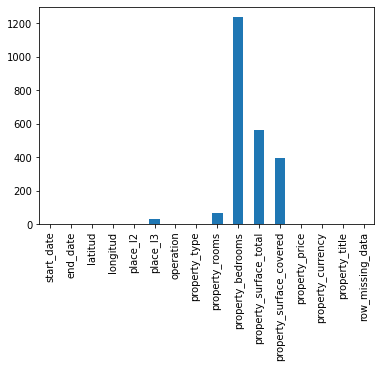

In [152]:
properties_dataset.groupby('row_missing_data').get_group(5).isna().sum().plot.bar()

In [153]:
properties_dataset.groupby('row_missing_data').get_group(10).isna().sum()

start_date                    0
end_date                      0
latitud                     398
longitud                    398
place_l2                      0
place_l3                     22
operation                     0
property_type                 0
property_rooms               80
property_bedrooms           206
property_surface_total       98
property_surface_covered     82
property_price                0
property_currency             0
property_title                0
row_missing_data              0
dtype: int64

Ahora que elegimos las columnas deseadas, veremos nuevamente los porcentajes por columna para preparar algunas imputaciones

In [154]:
def plot_missing_by_column(dataset):
    percent_missing = dataset.isna().sum() * 100 / len(dataset)
    plt.figure(figsize=(12, 6))
    percent_missing.plot.bar(x='index', rot=45)
    plt.xlabel("Columns")
    plt.ylabel("Percentage Missing")
    rows = dataset.shape[0]
    print(dataset.isna().sum() / rows * 100)

start_date                   0.000000
end_date                     0.000000
latitud                      4.052904
longitud                     4.052904
place_l2                     0.000000
place_l3                     0.564622
operation                    0.000000
property_type                0.000000
property_rooms               1.407688
property_bedrooms           11.857066
property_surface_total       5.406451
property_surface_covered     3.991028
property_price               0.000000
property_currency            0.000000
property_title               0.000000
row_missing_data             0.000000
dtype: float64


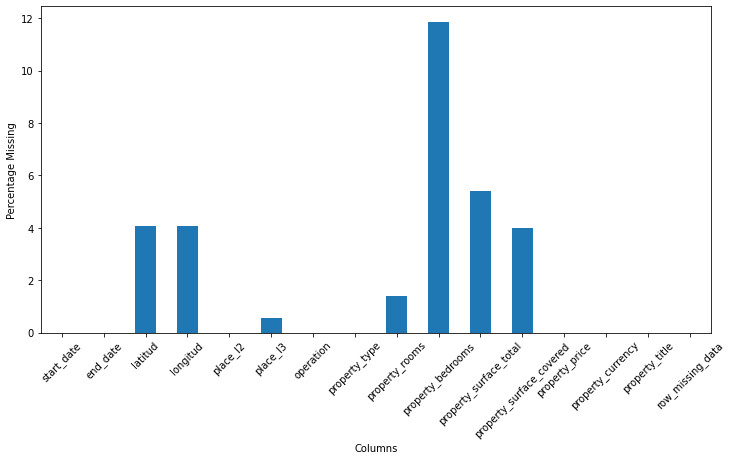

In [155]:
plot_missing_by_column(properties_dataset)

## Imputaciones

Ahora analizaremos columna a columna como podemos reparar esos datos.

#### Latitud y Longitud

In [156]:
len(properties_dataset[properties_dataset.latitud.isna()]), properties_dataset[properties_dataset.latitud.isna()].longitud.isna().sum()

(524, 524)

Como vemos, en esos 3730 los registros faltan ambos datos, veremos que datos sí están presentes en esos registros

start_date                    0.000000
end_date                      0.000000
latitud                     100.000000
longitud                    100.000000
place_l2                      0.000000
place_l3                      3.053435
operation                     0.000000
property_type                 0.000000
property_rooms                2.480916
property_bedrooms            13.358779
property_surface_total        5.343511
property_surface_covered      5.152672
property_price                0.000000
property_currency             0.000000
property_title                0.000000
row_missing_data              0.000000
dtype: float64


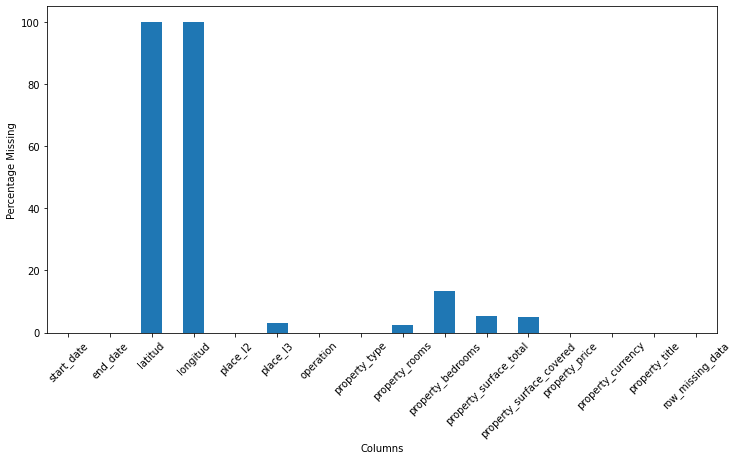

In [157]:
plot_missing_by_column(properties_dataset[properties_dataset.latitud.isna()])

In [158]:
properties_dataset[properties_dataset.latitud.isna()]['place_l3'].value_counts()

Palermo             117
Belgrano             90
Nuñez                41
Caballito            34
Recoleta             29
Villa Urquiza        29
Almagro              25
Barrio Norte         24
Flores               22
Villa Crespo         15
San Telmo            15
Balvanera            11
Constitución          8
Puerto Madero         6
San Nicolás           6
Once                  6
Congreso              5
Monserrat             4
Villa Pueyrredón      3
Villa del Parque      2
Liniers               2
Paternal              2
Abasto                2
Tribunales            2
Mataderos             1
San Cristobal         1
Colegiales            1
Parque Chas           1
Coghlan               1
Villa Devoto          1
Floresta              1
Saavedra              1
Name: place_l3, dtype: int64

In [159]:
percentage = properties_dataset[properties_dataset.latitud.isna()]['place_l3'].isna().sum() / len(properties_dataset[properties_dataset.latitud.isna()]['place_l3']) * 100
print(f"Los datos faltantes en la columna place_l3 representan el {round(percentage, 3)}%")

Los datos faltantes en la columna place_l3 representan el 3.053%


Para los que tienen el dato del barrio podríamos tomar como latitud/longitud

## Grafico de los barrios de CABA

In [6]:
# Proceso el archivo de los barrios de CABA
barrios = gpd.read_file('./mapa/barrios.geojson')
barrios.head()

,BARRIO,COMUNA,PERIMETRO,AREA,OBJETO,geometry
0,CHACARITA,15.0,7724.852955,3.115707e+06,BARRIO,"MULTIPOLYGON (((-58.45282 -34.59599, -58.45366..."
1,PATERNAL,15.0,7087.513295,2.229829e+06,BARRIO,"MULTIPOLYGON (((-58.46558 -34.59656, -58.46562..."
2,VILLA CRESPO,15.0,8131.857075,3.615978e+06,BARRIO,"MULTIPOLYGON (((-58.42375 -34.59783, -58.42495..."
3,VILLA DEL PARQUE,11.0,7705.389797,3.399596e+06,BARRIO,"MULTIPOLYGON (((-58.49461 -34.61487, -58.49479..."
4,ALMAGRO,5.0,8537.901368,4.050752e+06,BARRIO,"MULTIPOLYGON (((-58.41287 -34.61412, -58.41282..."


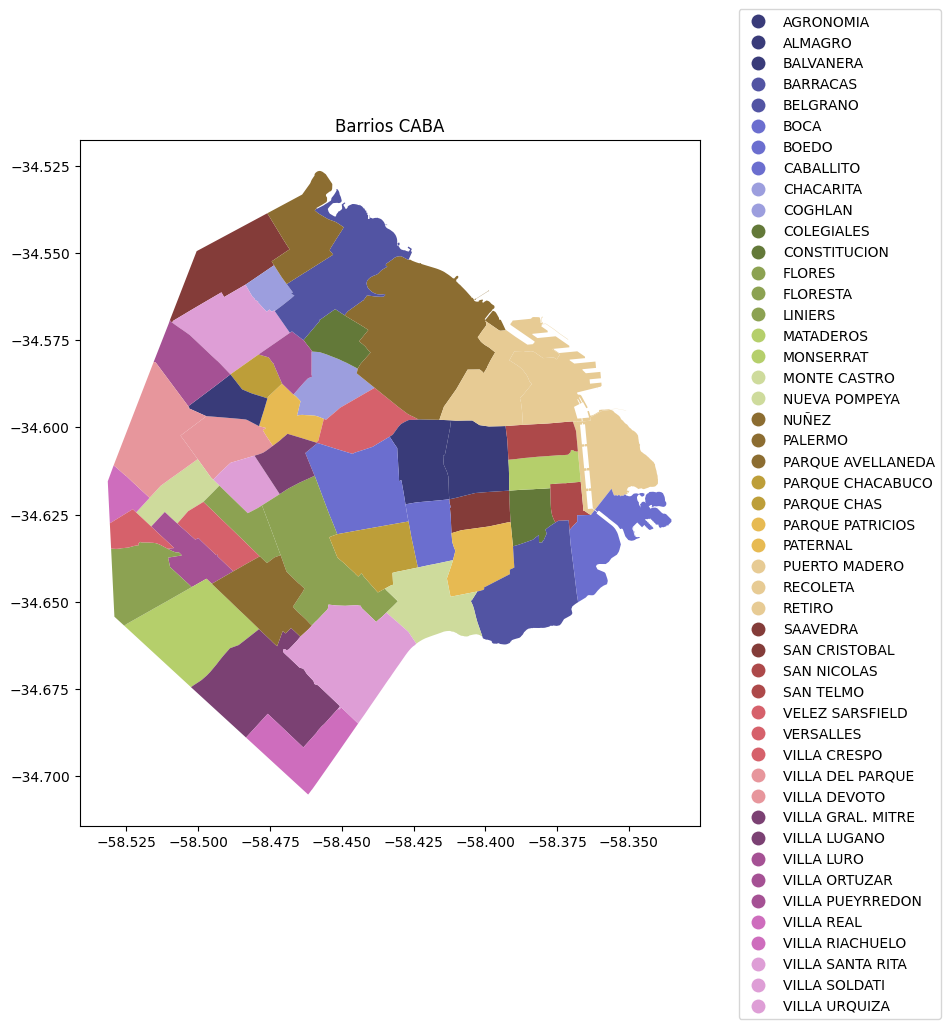

In [7]:
# Realizo el grafico de los barrios de CABA
fig, ax = plt.subplots(figsize=(8,10))
barrios.plot(column='BARRIO', categorical=True, legend=True, ax=ax, cmap='tab20b')

leg = ax.get_legend()
leg.set_bbox_to_anchor((1.4, 1.2))

ax.set(title='Barrios CABA')
plt.show()